# Визуализация результатов оптимального контроля XY-Гамильтониана для получения не сильно запутанного состояния

В качестве конечного состояния используется первое состояние с максимальной энтропией (почти максимальной) $\Omega t = 0.4$ 


In [1]:
import json

In [2]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

In [3]:
import pathlib
import sys

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [4]:
%reload_ext autoreload
%autoreload 2

import bec
import qoc_xy2zz

In [5]:
cases_path = pathlib.Path(f"../assets/{qoc_xy2zz.__name__}/results")

In [6]:
results = {}
for result_path in cases_path.iterdir():
    result_data = json.loads(result_path.read_text())
    task = qoc_xy2zz.OptimizeTask(**result_data.pop("task"))
    results[f"{result_path.stem}"] = qoc_xy2zz.OptimizeTaskResult(
        task=task,
        **result_data,
    )

len(results)

102

In [7]:
def plot_all(name, result, amps_offset=-6, ext=None, suptitle=True, fontsize=12, label_prefix=""):
    tspan = np.linspace(0, result.task.t_target, result.task.n_ts)[:amps_offset]
    final_amps = list(zip(*result.final_amps[:amps_offset]))
    psi_target = result.task.psi_target_constructor()
    psi_initial = result.task.psi_initial_constructor()
    H_d = result.task.H_d_constructor()
    H_c = result.task.H_c_constructor()
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    if suptitle is True:
        fig.suptitle(f"{name} | {result.fid_err} | {result.task}")

    def set_label(ax, label):
        ax.text(ax.get_xlim()[0] - (ax.get_xlim()[1] - ax.get_xlim()[0]) / 5.5, ax.get_ylim()[1], label, fontdict={"fontsize": 12, "fontweight": "bold"})
        
    ax = axes[0]
    local_line_types = iter(("solid", (0, (5, 5)),  "dotted", (0, (3, 5, 1, 5))))
    common_line_types = iter(("-", "--"))
    for i in range(len(result.task.controls)):
        control = result.task.controls[i]
        color = None
        control_type = None
        control_qubit_number = None
        if isinstance(control, (tuple, list)):
            # color = "blue"
            if len(control) == 2:
                control_type, control_qubit_number = control
            else:
                control_type, = control
                control_qubit_number = i
            control_qubit_number += 1
            line_type = next(local_line_types)
        else:
            # color = "black"
            line_type = next(common_line_types)
            control_type = control
            
        control_label = {
            "z": rf"$S^z_{control_qubit_number}$",
            "x": rf"$S^x_{control_qubit_number}$",
            "y": rf"$S^y_{control_qubit_number}$",
            "xx": rf"$S^x_1S^x_2$",
            "yy": rf"$S^y_1S^y_2$",
            "xxyy": rf"$S^x_1S^x_2 - S^y_1S^y_2$",
            "z^2": rf"$(S^z_{control_qubit_number})^2$",
        }[control_type]
        
        ax.step(
            tspan,
            # np.hstack((final_amps[i], final_amps[i][-1])),
            final_amps[i],
            linestyle=line_type, 
            where="post",
            alpha=0.7,
            label=f"{control_label}",
        )

        ax.set_xlabel("Time, t", fontsize=fontsize)
        ax.set_ylabel("Control amplitude", fontsize=fontsize)
        ax.legend()
    ax.grid()
    set_label(ax, f"{label_prefix}1")
    

    evolution_controled = qutip.mesolve(
        [H_d] + [(H_c[i], np.array(final_amps[i]))  for i in range(len(H_c))],
        psi_initial,
        tspan,
        options=qutip.Options(nsteps=1e6),
    )
    evolution_drift = qutip.mesolve(
        H_d,
        psi_initial,
        tspan,
        options=qutip.Options(nsteps=1e6),
    )
    
    ax = axes[1]
    ax.plot(
        tspan,
        [qutip.metrics.fidelity(psi_target, psi) for psi in evolution_controled.states],
        "-",
        # alpha=0.7,
        label="GRAPE",
    )

    ax.plot(
        tspan,
        [qutip.metrics.fidelity(psi_target, psi) for psi in evolution_drift.states],
        "--",
        # alpha=0.7,
        label="drift",
    )
    ax.set_xlabel("Time, t", fontsize=fontsize)
    ax.set_ylabel("Fidelity, F", fontsize=fontsize)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid()
    set_label(ax, f"{label_prefix}2")
    
    ax = axes[2]
    ax.plot(
        tspan,
        [qutip.entropy_vn(qutip.ptrace(psi, [0, 1])) for psi in evolution_controled.states],
        "-",
        #alpha=0.7,
        label="GRAPE",
    )
    ax.plot(
        tspan,
        [qutip.entropy_vn(qutip.ptrace(psi, [0, 1])) for psi in evolution_drift.states],
        "--",
        #alpha=0.7,
        label="drift",
    )
    ax.plot(
        tspan[-1],
        qutip.entropy_vn(qutip.ptrace(psi_target, [0, 1])),
        "*k",
        alpha=0.7,
        label="target",
    )
    ax.set_xlabel("Time, t", fontsize=fontsize)
    ax.set_ylabel("Entanglement, E", fontsize=fontsize)
    ax.legend()
    ax.grid()
    set_label(ax, f"{label_prefix}3")
    
    figdir = pathlib.Path.cwd().parent / "assets" / qoc_xy2zz.__name__ / "figures"
    figdir.mkdir(parents=True, exist_ok=True)
    
    if ext is not None:
        plt.tight_layout()
        plt.savefig(figdir / f"{name}.{ext}", )
    return fig, axes

## Обзор результатов

100%|██████████| 102/102 [00:02<00:00, 45.88it/s]


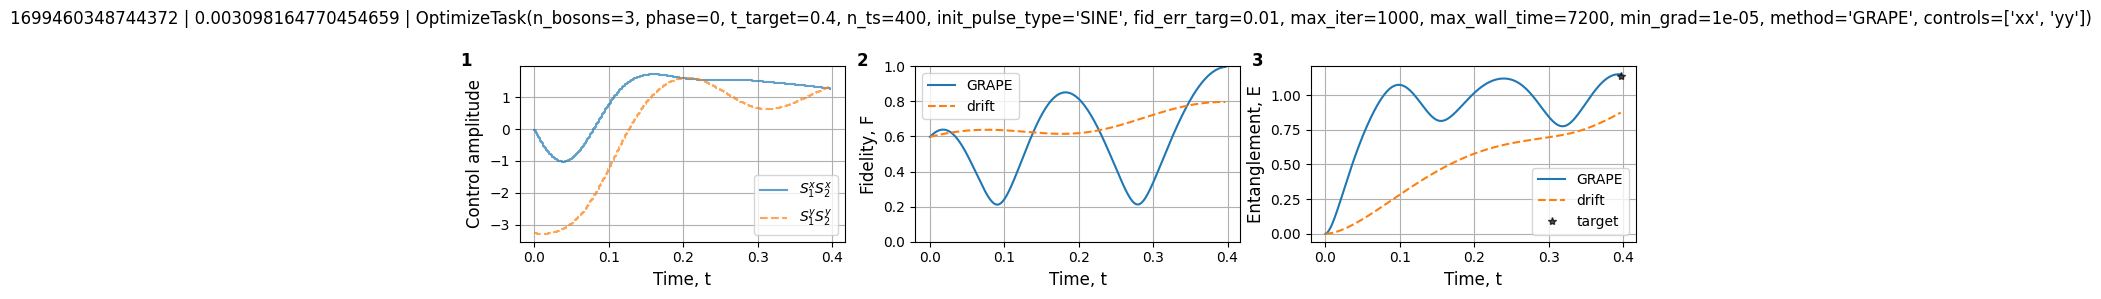

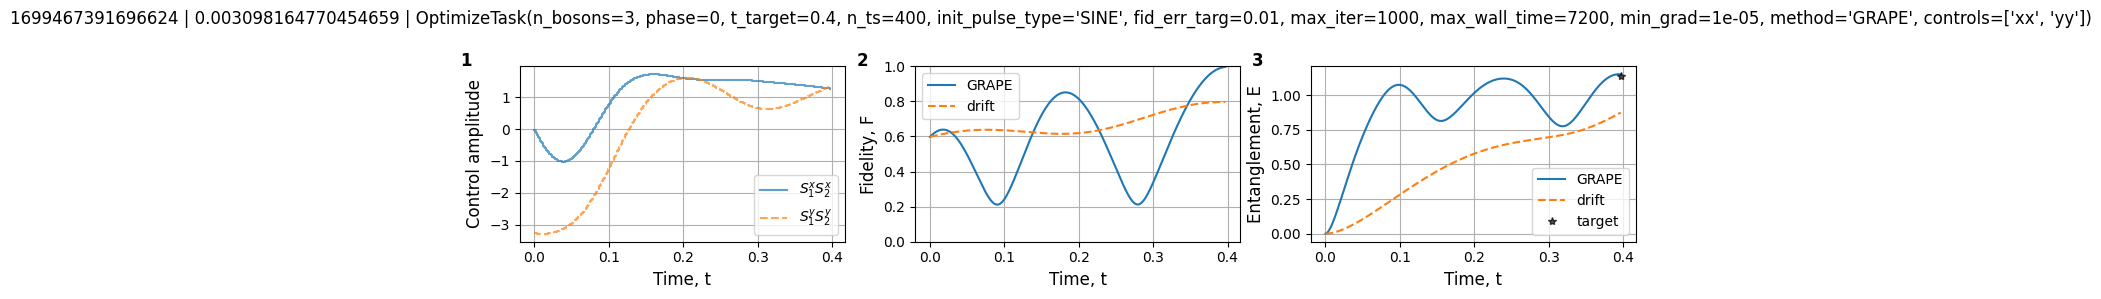

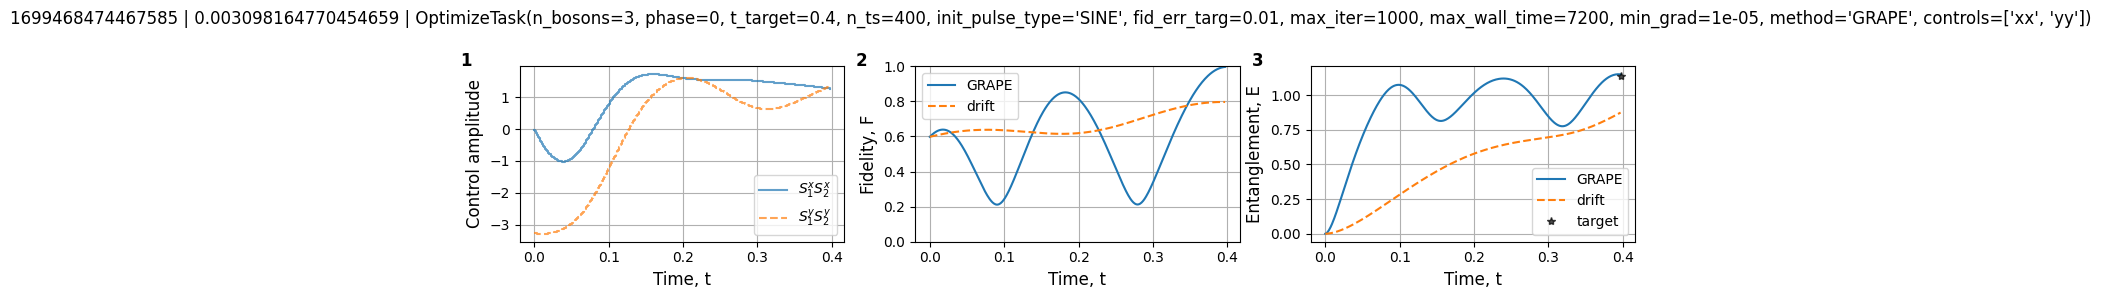

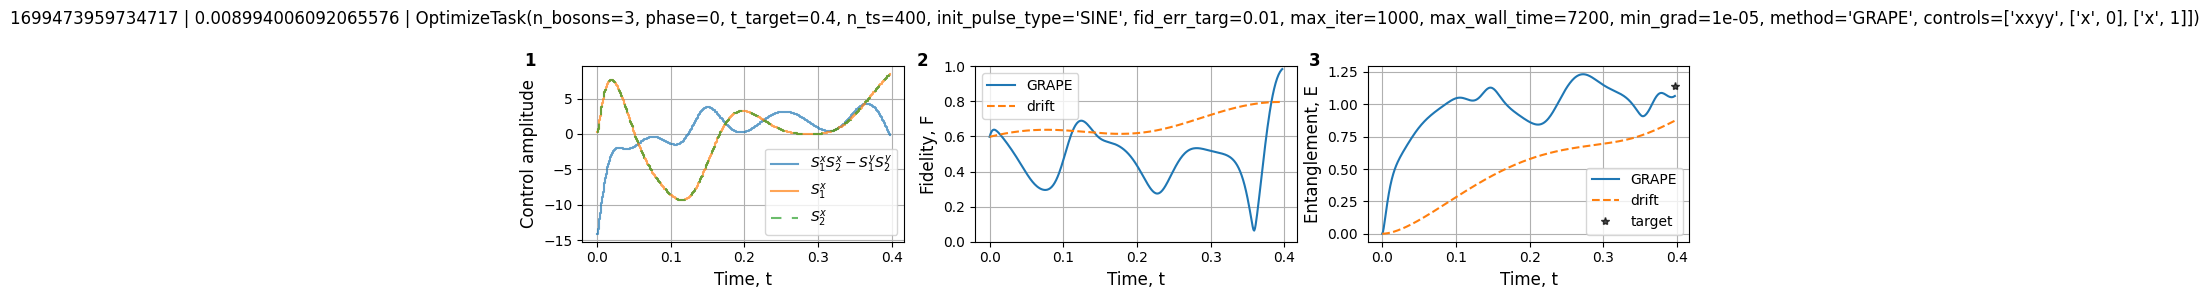

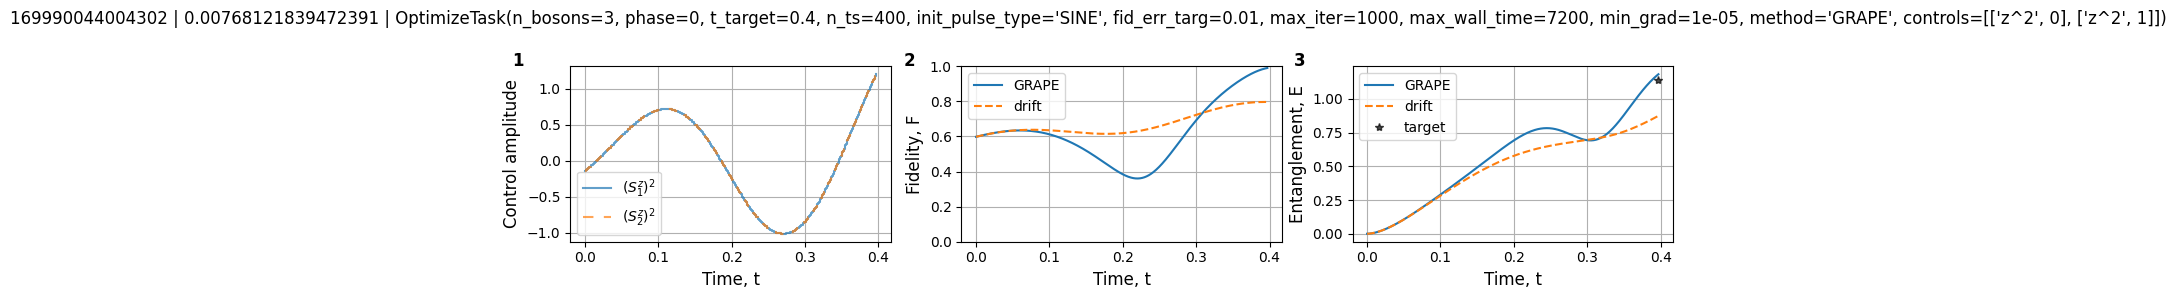

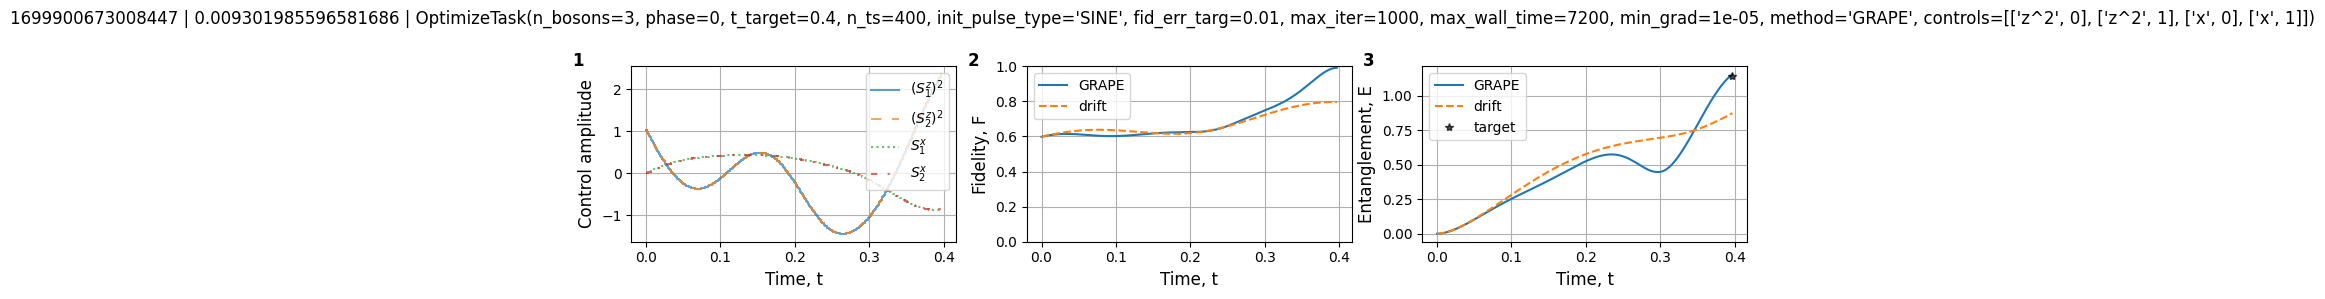

In [8]:
for name, r in tqdm(sorted(list(results.items()))):
    if r.task.t_target != 0.4: continue
    if r.task.init_pulse_type != "SINE": continue
    if r.fid_err > 1e-2: continue
    # if "xxyy" not in r.task.controls: continue
    # if "z^2" not in (c[0] for c in r.task.controls if isinstance(c, (tuple, list))) or r.task.init_pulse_type != "SINE": continue 
    
    plot_all(
        name, 
        r, 
        amps_offset=-3, 
        ext="eps",
        fontsize=12,  
    )

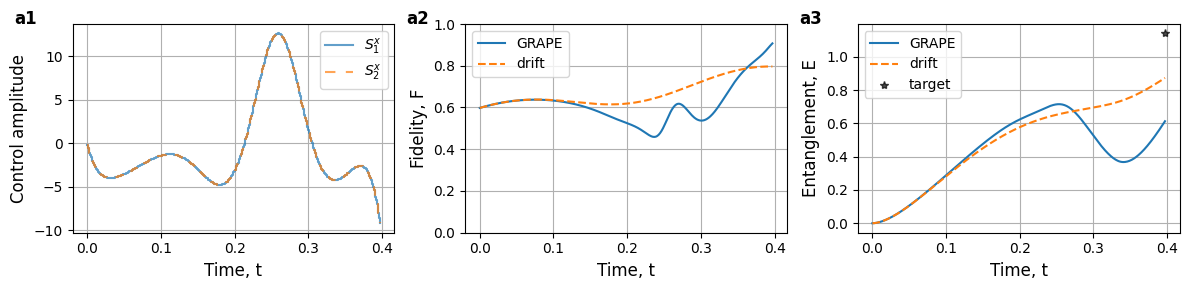

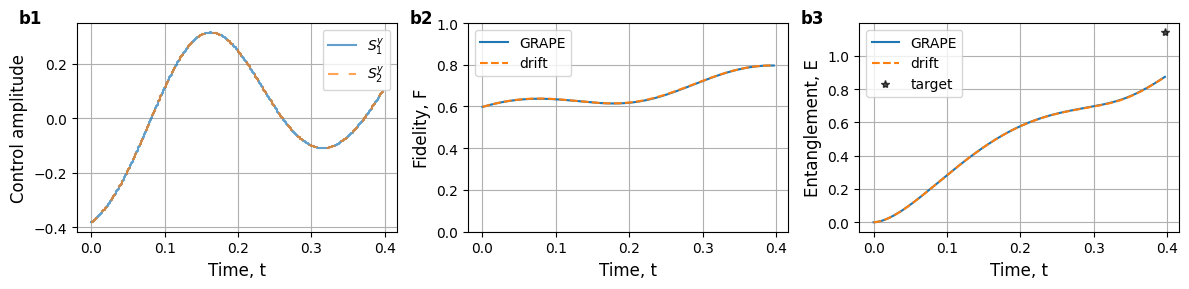

In [9]:
label_prefixes = iter("abcdefghgk")
for name in ["1699460491612673", "1699460126205218"]:  # rotation
    r = results[name]
    plot_all(
        name, 
        r, 
        amps_offset=-3, 
        ext="eps",
        suptitle=False,
        fontsize=12,
        label_prefix=next(label_prefixes)
    )

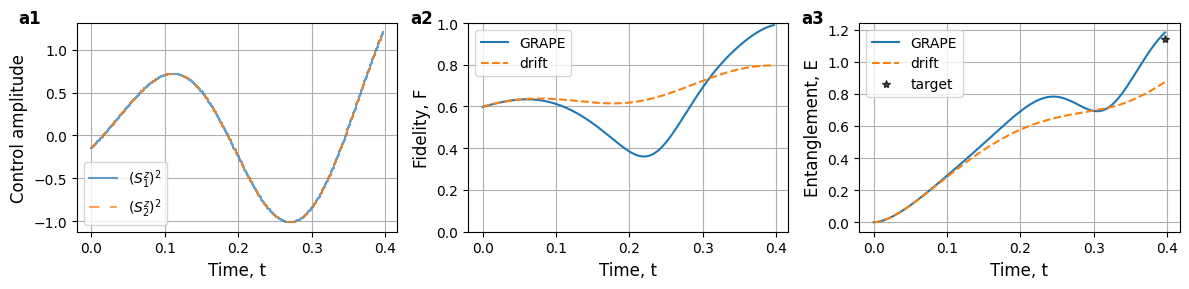

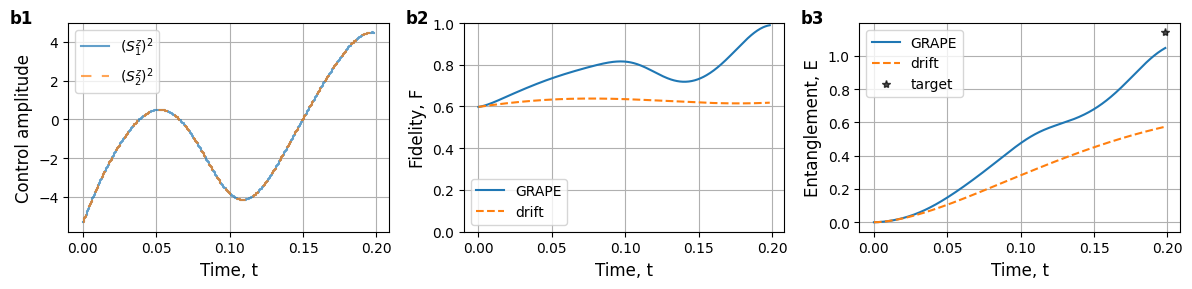

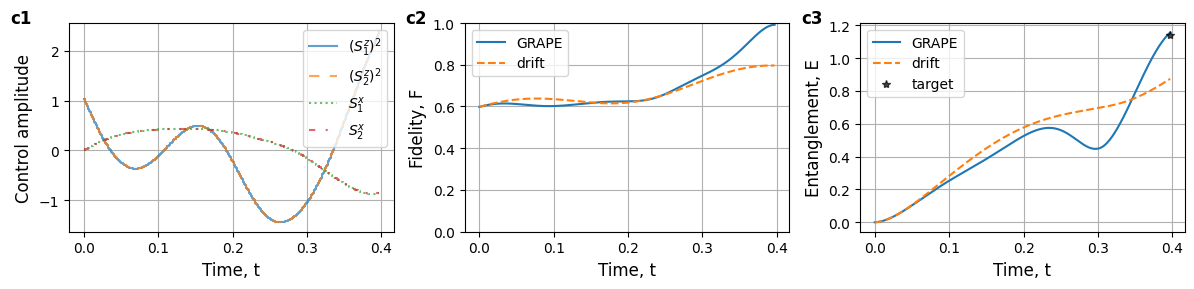

In [10]:
label_prefixes = iter("abcdefghgk")
for name in ["169990044004302", "1699900641228075", "1699900673008447"]:  # Z^2
    r = results[name]
    plot_all(
        name, 
        r, 
        amps_offset=-3, 
        ext="eps",
        suptitle=False,
        fontsize=12,
        label_prefix=next(label_prefixes)
    )

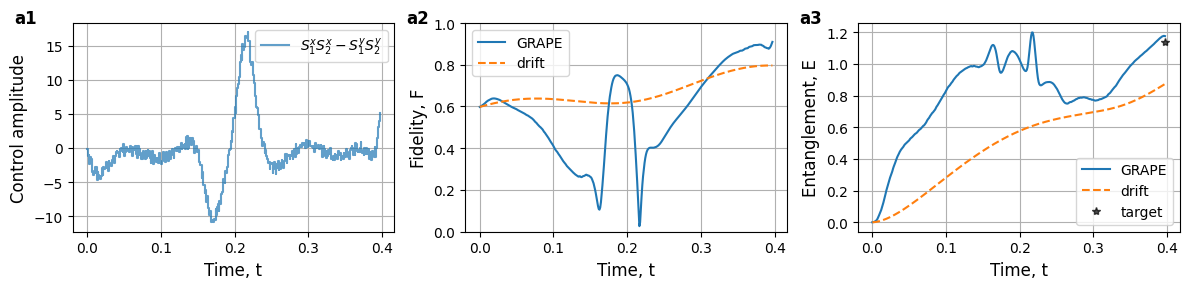

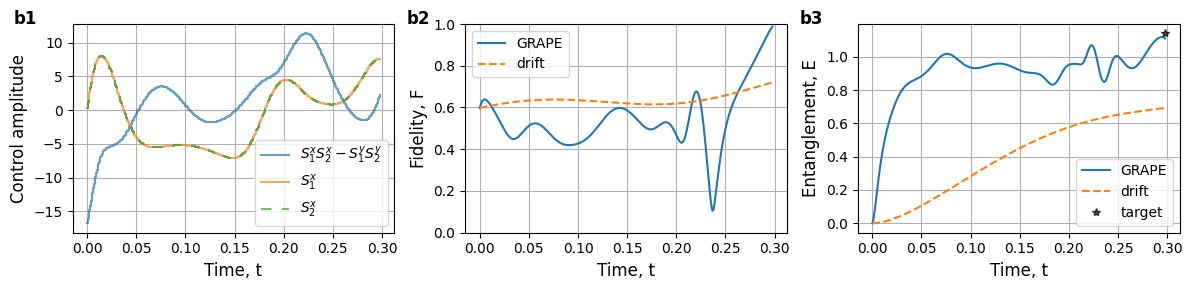

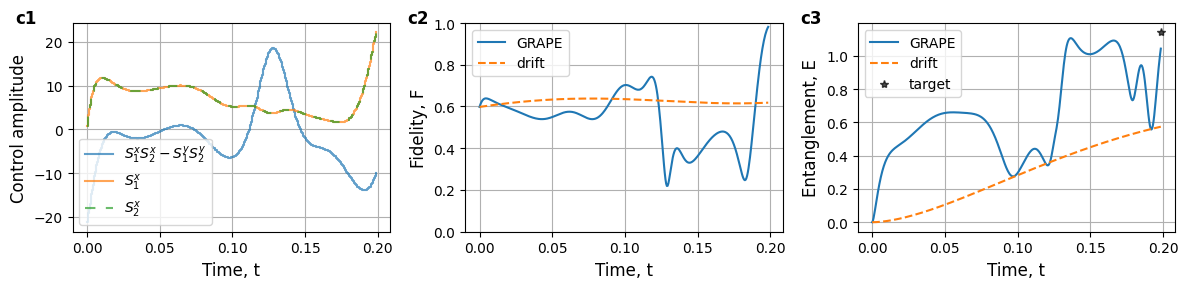

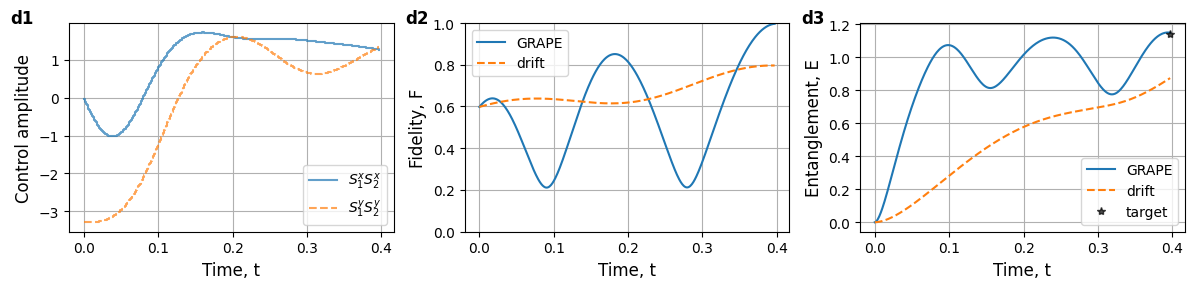

In [11]:
label_prefixes = iter("abcdefghgk")
for name in ["16994742017557", "1699473775251138", "1699474341981941", "1699460348744372",]:
    r = results[name]
    plot_all(
        name, 
        r, 
        amps_offset=-3, 
        ext="eps",
        suptitle=False,
        fontsize=12,
        label_prefix=next(label_prefixes)
    )